In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
import torch
from torch.utils.data import DataLoader

import numpy as np
import tensorly as tl
import scipy.signal
import matplotlib.pyplot as plt
import copy

In [3]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
%load_ext autoreload
%autoreload 2

import tensor_regression as tr
import tensor_regression.util
from tensor_regression import standard_tensor_regression_JOSH as STR

import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers
from basic_neural_processing_modules import h5_handling
from basic_neural_processing_modules import misc

In [4]:
%matplotlib notebook

In [5]:
dir_data = r'/media/rich/bigSSD/for_Josh/'
fileName_X_data = r'positions_convDR_meanSub_s2pInd.h5'
fileName_y_data = r'neural_data.h5'
positions = h5_handling.simple_load(directory=dir_data, fileName=fileName_X_data)
neural_data = h5_handling.simple_load(directory=dir_data, fileName=fileName_y_data)

In [6]:
torch_helpers.show_cuda_devices()
DEVICE = tr.util.set_device(use_GPU=True, verbose=True)

1 device(s) found.
0 GeForce RTX 3090
GPU is enabled.


In [7]:
pos_array = torch.tensor(positions['positions_convDR_meanSub_s2pInd'])
print(f'pos_array.shape = {pos_array.shape}')

ic = neural_data['is_cell']
good_ROIs = neural_data['good_ROIs']
neural_array = torch.tensor(neural_data['dFoF'][ic][good_ROIs]).T

print(f'neural_array.shape = {neural_array.shape}')

# win_range = [-120*3, -120*-1]
win_range = [-30, 30]

pos_array.shape = torch.Size([108000, 2744])
neural_array.shape = torch.Size([108000, 811])


In [8]:
X = copy.deepcopy(pos_array)
y = copy.deepcopy(neural_array[:,0])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


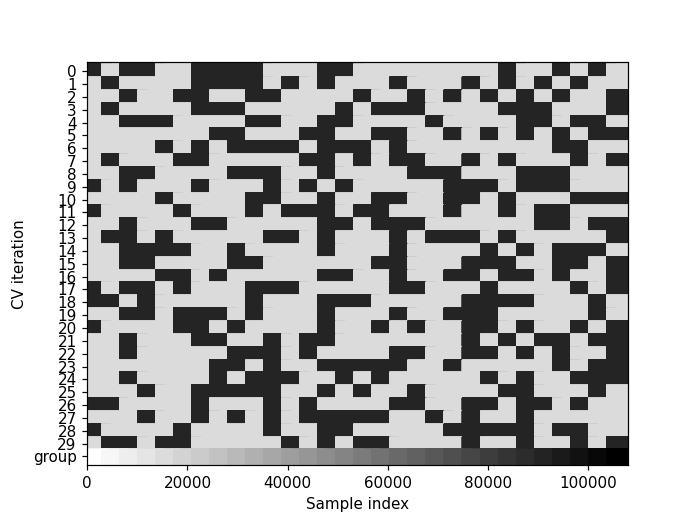

In [9]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import cross_validation

from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                 StratifiedKFold, GroupShuffleSplit,
                                 GroupKFold, StratifiedShuffleSplit)
Fs = 30
group_len = 60*2 * Fs # seconds * Fs
n_splits = 30
test_size = 0.4
groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx_all = cross_validation.make_cv_indices(cv,
                                        groups,
                                        lw=10,
                                        plot_pref=True)

In [76]:
import torch
from tqdm.notebook import tqdm, trange

%load_ext autoreload
%autoreload 2
from tensor_regression import standard_tensor_regression_JOSH as STR

DEVICE = tr.util.set_device(use_GPU=True)

# h_vals = np.logspace(-50, 2, num=30, endpoint=True, base=10.0)
# h_vals = np.int64(np.linspace(1, 300, num=30, endpoint=True))
# h_vals = np.logspace(-5.5, -3.5, num=20, endpoint=True)
h_vals = np.array([1e-0]*1)


loss_all = []
params_all = []
EV_all = []
for ii, val in enumerate(h_vals):
    for cv_iter, cv_idx in tqdm(enumerate(cv_idx_all)):
        X_train = X[cv_idx[0]]
        y_train = y[cv_idx[0]]
        X_test = X[cv_idx[1]]
        y_test = y[cv_idx[1]]
        
        import gc
        if 'cpmlr' in globals():
            print('deleting cpmlr')
            del cpmlr
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()


        print(f'hyperparameter val: {val}')
        dataloader, dataset, sampler = tr.util.make_WindowedDataloader(X_train, y_train, win_range=win_range, batch_size=10000, drop_last=True)

        cpmlr = STR.CP_linear_regression(dataloader.sample_shape,
                                         rank=3,
                                         non_negative=[False, False],
                                         weights=None,
                                         Bcp_init=None,
                                             Bcp_init_scale=0.1,
#                                              Bcp_init_scale=0.005,
#                                          Bcp_init_scale=0.02,
                                         device=DEVICE,
                                         softplus_kwargs={
                                             'beta': 50,
                                             'threshold':1}
                                         )
        
        # tic = time.time()
#         cpmlr.fit_batch_Adam(   dataloader,
#                                 lambda_L2=h_vals[ii], 
#                                 max_iter=200, 
#                                 tol=1e-50, 
#                                 patience=10,
#                                 verbose=1,
#                                 running_loss_logging_interval=1,
#                                 LBFGS_kwargs={
#                                     'lr' : 10, 
#                                     'max_iter' : 20, 
#                                     'max_eval' : None, 
#                                     'tolerance_grad' : 1e-07, 
#                                     'tolerance_change' : 1e-09, 
#                                     'history_size' : 100, 
#                                     'line_search_fn' : "strong_wolfe"
#                                 }
#                             )

#         cpmlr.fit_batch_Adam(dataloader,
#                     lambda_L2=h_vals[ii], 
#                     max_iter=4000, 
#                     tol=1e-8, 
#                     patience=100,
#                     verbose=2,
#                     Adam_kwargs={
#                             'lr' : 0.001, 
#     #                             'betas' : (0.9, 0.999), 
#     #                             'eps' : 1e-08, 
#     #                             'weight_decay' : 0, 
#                             'amsgrad' : True
#                         }
#              )
    
        cpmlr.fit_batch_LBFGS(dataloader,
                    lambda_L2=h_vals[ii], 
                    max_iter=4000, 
                    tol=1e-8, 
                    patience=100,
                    verbose=2,
                    n_iter_inner=20,
                    LBFGS_kwargs={
                                    'lr' : 10, 
                                    'max_iter' : 20, 
                                    'max_eval' : None, 
                                    'tolerance_grad' : 1e-07, 
                                    'tolerance_change' : 1e-09, 
                                    'history_size' : 100, 
                                    'line_search_fn' : "strong_wolfe"
                                }
             )

        # print(time.time() - tic)
        final_loss = cpmlr.loss_running[-1]
        print(f'loss: {final_loss}')

        loss_all.append(final_loss)
        params_all.append(cpmlr.get_params())

        y_pred = cpmlr.predict(X_test, y_test)
        EV =similarity.EV(y_test, y_pred)[0]
        print(f'EV: {EV}')
        EV_all.append(EV)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU is enabled.


0it [00:00, ?it/s]

deleting cpmlr
hyperparameter val: 1.0
Epoch: 0, Inner iteration: 0, Loss: 20.41302490234375  ;  Variance ratio (y_hat / y_true): 0.000907751516348648
Epoch: 0, Inner iteration: 1, Loss: 18.2464656829834  ;  Variance ratio (y_hat / y_true): 0.07721958984688926
Epoch: 0, Inner iteration: 2, Loss: 16.263532638549805  ;  Variance ratio (y_hat / y_true): 0.09687652314203933
Epoch: 0, Inner iteration: 3, Loss: 15.204940795898438  ;  Variance ratio (y_hat / y_true): 0.12064564361226232
Epoch: 0, Inner iteration: 4, Loss: 14.47642707824707  ;  Variance ratio (y_hat / y_true): 0.15096603061361408
Epoch: 0, Inner iteration: 5, Loss: 13.976818084716797  ;  Variance ratio (y_hat / y_true): 0.1725697409402089
Epoch: 0, Inner iteration: 6, Loss: 13.58938217163086  ;  Variance ratio (y_hat / y_true): 0.1977630881165525
Epoch: 0, Inner iteration: 7, Loss: 13.102473258972168  ;  Variance ratio (y_hat / y_true): 0.22743872524034825
Epoch: 0, Inner iteration: 8, Loss: 12.736496925354004  ;  Variance rat

Epoch: 0, Inner iteration: 14, Loss: 8.164034843444824  ;  Variance ratio (y_hat / y_true): 0.5926713799744869
Epoch: 0, Inner iteration: 15, Loss: 8.13841724395752  ;  Variance ratio (y_hat / y_true): 0.595049886644745
Epoch: 0, Inner iteration: 16, Loss: 8.112146377563477  ;  Variance ratio (y_hat / y_true): 0.5945845059892596
Epoch: 0, Inner iteration: 17, Loss: 8.085661888122559  ;  Variance ratio (y_hat / y_true): 0.5931571882101033
Epoch: 0, Inner iteration: 18, Loss: 8.061666488647461  ;  Variance ratio (y_hat / y_true): 0.5958061227870963
Epoch: 0, Inner iteration: 19, Loss: 8.032816886901855  ;  Variance ratio (y_hat / y_true): 0.6041276894779791
Epoch: 0, Inner iteration: 0, Loss: 9.23935317993164  ;  Variance ratio (y_hat / y_true): 0.6199119105882901
Epoch: 0, Inner iteration: 1, Loss: 8.821044921875  ;  Variance ratio (y_hat / y_true): 0.5687184580628655
Epoch: 0, Inner iteration: 2, Loss: 8.706279754638672  ;  Variance ratio (y_hat / y_true): 0.5619839384815409
Epoch: 0, 

Epoch: 1, Inner iteration: 9, Loss: 8.094100952148438  ;  Variance ratio (y_hat / y_true): 0.6144876886917763
Epoch: 1, Inner iteration: 10, Loss: 8.070791244506836  ;  Variance ratio (y_hat / y_true): 0.6181928952495233
Epoch: 1, Inner iteration: 11, Loss: 8.050596237182617  ;  Variance ratio (y_hat / y_true): 0.6199809202727814
Epoch: 1, Inner iteration: 12, Loss: 8.026324272155762  ;  Variance ratio (y_hat / y_true): 0.6227718899013014
Epoch: 1, Inner iteration: 13, Loss: 8.008387565612793  ;  Variance ratio (y_hat / y_true): 0.6233269831381978
Epoch: 1, Inner iteration: 14, Loss: 7.990468978881836  ;  Variance ratio (y_hat / y_true): 0.6252578613243741
Epoch: 1, Inner iteration: 15, Loss: 7.971993446350098  ;  Variance ratio (y_hat / y_true): 0.6248389186336127
Epoch: 1, Inner iteration: 16, Loss: 7.9487504959106445  ;  Variance ratio (y_hat / y_true): 0.6254935603006456
Epoch: 1, Inner iteration: 17, Loss: 7.931539535522461  ;  Variance ratio (y_hat / y_true): 0.626330454860557
Ep

KeyboardInterrupt: 

In [79]:
        cpmlr.fit_batch_LBFGS(dataloader,
                    lambda_L2=1e-0, 
                    max_iter=4000, 
                    tol=1e-8, 
                    patience=100,
                    verbose=2,
                    n_iter_inner=20,
                    LBFGS_kwargs={
                                    'lr' : 10, 
                                    'max_iter' : 20, 
                                    'max_eval' : None, 
                                    'tolerance_grad' : 1e-07, 
                                    'tolerance_change' : 1e-09, 
                                    'history_size' : 100, 
                                    'line_search_fn' : "strong_wolfe"
                                }
             )

Epoch: 0, Inner iteration: 0, Loss: 8.023838996887207  ;  Variance ratio (y_hat / y_true): 0.6308153256544783
Epoch: 0, Inner iteration: 1, Loss: 7.976146697998047  ;  Variance ratio (y_hat / y_true): 0.6310757087688271
Epoch: 0, Inner iteration: 2, Loss: 7.91072416305542  ;  Variance ratio (y_hat / y_true): 0.6251177860693742
Epoch: 0, Inner iteration: 3, Loss: 7.863635540008545  ;  Variance ratio (y_hat / y_true): 0.6262129924479501
Epoch: 0, Inner iteration: 4, Loss: 7.825902938842773  ;  Variance ratio (y_hat / y_true): 0.6229181536124134
Epoch: 0, Inner iteration: 5, Loss: 7.7893595695495605  ;  Variance ratio (y_hat / y_true): 0.6236278943250927
Epoch: 0, Inner iteration: 6, Loss: 7.763171195983887  ;  Variance ratio (y_hat / y_true): 0.6234345742501184
Epoch: 0, Inner iteration: 7, Loss: 7.743413925170898  ;  Variance ratio (y_hat / y_true): 0.6247461793152922
Epoch: 0, Inner iteration: 8, Loss: 7.728704929351807  ;  Variance ratio (y_hat / y_true): 0.6233237616798034
Epoch: 0, 

Epoch: 0, Inner iteration: 15, Loss: 7.5590949058532715  ;  Variance ratio (y_hat / y_true): 0.6389408672546375
Epoch: 0, Inner iteration: 16, Loss: 7.543688774108887  ;  Variance ratio (y_hat / y_true): 0.6410626628206192
Epoch: 0, Inner iteration: 17, Loss: 7.532052993774414  ;  Variance ratio (y_hat / y_true): 0.6417586572400062
Epoch: 0, Inner iteration: 18, Loss: 7.519044399261475  ;  Variance ratio (y_hat / y_true): 0.6441975970172974
Epoch: 0, Inner iteration: 19, Loss: 7.509028434753418  ;  Variance ratio (y_hat / y_true): 0.6430344419082283
Epoch: 0, Inner iteration: 0, Loss: 8.184710502624512  ;  Variance ratio (y_hat / y_true): 0.6714217233892056
Epoch: 0, Inner iteration: 1, Loss: 7.733757019042969  ;  Variance ratio (y_hat / y_true): 0.6239788587469531
Epoch: 0, Inner iteration: 2, Loss: 7.682482719421387  ;  Variance ratio (y_hat / y_true): 0.6237640697281803
Epoch: 0, Inner iteration: 3, Loss: 7.6533403396606445  ;  Variance ratio (y_hat / y_true): 0.6221095904590792
Epo

KeyboardInterrupt: 

In [27]:
        cpmlr.fit_batch_LBFGS(dataloader,
                    lambda_L2=4e-1, 
                    max_iter=4000, 
                    tol=1e-8, 
                    patience=100,
                    verbose=2,
                    n_iter_inner=20,
                    LBFGS_kwargs={
                                    'lr' : 10, 
                                    'max_iter' : 20, 
                                    'max_eval' : None, 
                                    'tolerance_grad' : 1e-07, 
                                    'tolerance_change' : 1e-09, 
                                    'history_size' : 100, 
                                    'line_search_fn' : "strong_wolfe"
                                }
             )

Epoch: 0, Inner iteration: 0, Loss: 5.919914245605469  ;  Variance ratio (y_hat / y_true): 0.7648544454309805
Epoch: 0, Inner iteration: 1, Loss: 5.892970085144043  ;  Variance ratio (y_hat / y_true): 0.768619211018518
Epoch: 0, Inner iteration: 2, Loss: 5.877310752868652  ;  Variance ratio (y_hat / y_true): 0.7666839545860133
Epoch: 0, Inner iteration: 3, Loss: 5.86337947845459  ;  Variance ratio (y_hat / y_true): 0.7672075835307728
Epoch: 0, Inner iteration: 4, Loss: 5.863377571105957  ;  Variance ratio (y_hat / y_true): 0.7671955113937178
Epoch: 0, Inner iteration: 5, Loss: 5.863377571105957  ;  Variance ratio (y_hat / y_true): 0.7671955113937178
Epoch: 0, Inner iteration: 6, Loss: 5.863377571105957  ;  Variance ratio (y_hat / y_true): 0.7671955113937178
Epoch: 0, Inner iteration: 7, Loss: 5.863377571105957  ;  Variance ratio (y_hat / y_true): 0.7671955113937178
Epoch: 0, Inner iteration: 8, Loss: 5.863377571105957  ;  Variance ratio (y_hat / y_true): 0.7671955113937178
Epoch: 0, In

Epoch: 0, Inner iteration: 15, Loss: 5.847278594970703  ;  Variance ratio (y_hat / y_true): 0.7667046400769467
Epoch: 0, Inner iteration: 16, Loss: 5.847278594970703  ;  Variance ratio (y_hat / y_true): 0.7667046400769467
Epoch: 0, Inner iteration: 17, Loss: 5.847278594970703  ;  Variance ratio (y_hat / y_true): 0.7667046400769467
Epoch: 0, Inner iteration: 18, Loss: 5.847278594970703  ;  Variance ratio (y_hat / y_true): 0.7667046400769467
Epoch: 0, Inner iteration: 19, Loss: 5.847278594970703  ;  Variance ratio (y_hat / y_true): 0.7667046400769467
Epoch: 0, Inner iteration: 0, Loss: 6.037919998168945  ;  Variance ratio (y_hat / y_true): 0.7666692928844289
Epoch: 0, Inner iteration: 1, Loss: 5.934394836425781  ;  Variance ratio (y_hat / y_true): 0.7694741754017674
Epoch: 0, Inner iteration: 2, Loss: 5.906765460968018  ;  Variance ratio (y_hat / y_true): 0.7695132759990583
Epoch: 0, Inner iteration: 3, Loss: 5.88995361328125  ;  Variance ratio (y_hat / y_true): 0.7672723669171954
Epoch:

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


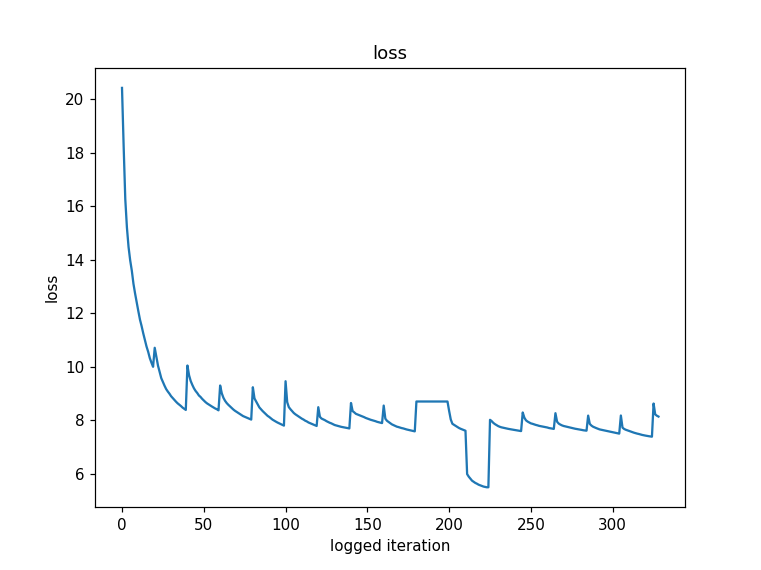

<IPython.core.display.Javascript object>


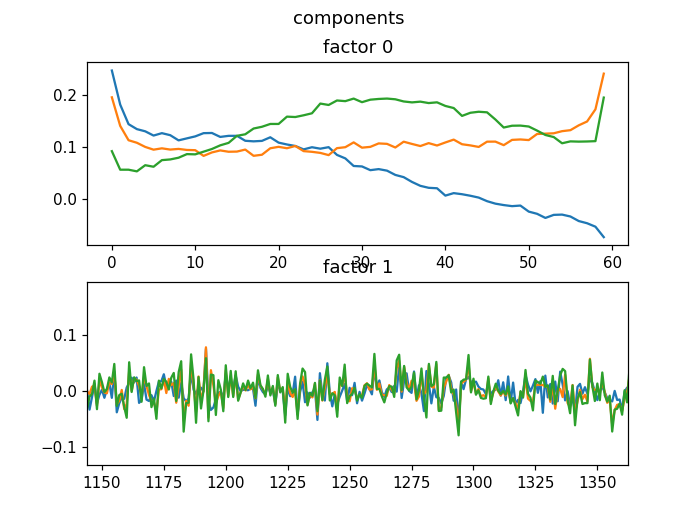

In [80]:
cpmlr.plot_outputs()

In [ ]:
plt.figure()
plt.plot(y)
plt.plot(cpmlr.predict(X[np.sort(cv_idx[1])], y[np.sort(cv_idx[1])]))
# plt.plot(trace_test*10)

In [33]:
dataset[100][0][None,...].shape

torch.Size([1, 60, 2744])

In [59]:
ii

0

In [58]:
cpmlr.predict(dataset[ii][0][None,...]).shape

ValueError: Incorrect shapes for inner product along 2 common modes.tensor_1.shape=[1, 0, 2744], tensor_2.shape=[60, 2744, 1]

In [72]:
dataloader_test, dataset_test, sampler_test = tr.util.make_WindowedDataloader(X_test, y_test, win_range=win_range, batch_size=10000, drop_last=True)

In [73]:
test = np.array([ cpmlr.predict(dataset_test[ii][0][None,...]) for ii in range(100,10000)])

<IPython.core.display.Javascript object>


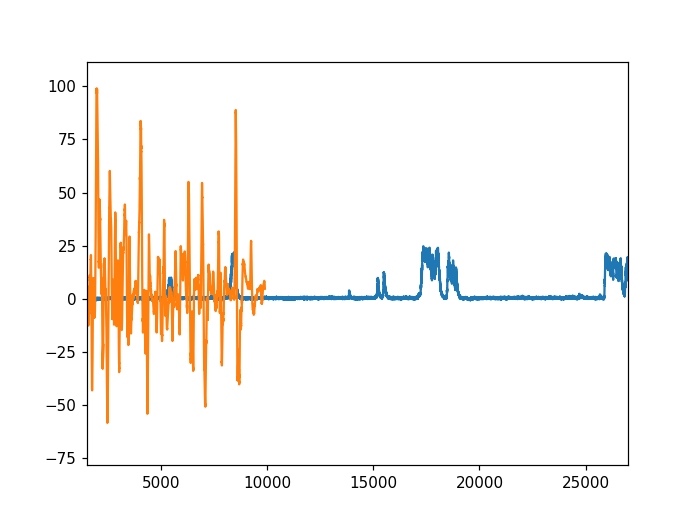

In [74]:
plt.figure()
plt.plot(y_test[100:])
plt.plot(test)